Descarga del Dataset

In [1]:
!wget -q https://github.com/simple-icons/simple-icons/archive/refs/heads/develop.zip
!unzip -q develop.zip

In [2]:
# Instalar ImageMagick (para convertir a PNG)
!apt-get install -y imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libilmbase25
  libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libopenexr25
  libwmflite-0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-uka

In [3]:
#Convertir TODOS los logos a PNG 64×64, mejor aprendizaje para ek GAN
import os
from pathlib import Path
import subprocess

src = Path("simple-icons-develop/icons")
# Create a subdirectory for ImageFolder to treat as a class
dst_base = Path("logos")
dst_class = dst_base / "all_logos" # New line

os.makedirs(dst_class, exist_ok=True) # Changed to dst_class

for svg in src.glob("*.svg"):
    png_path = dst_class / f"{svg.stem}.png" # Changed to dst_class
    subprocess.run(["convert", str(svg), "-background", "white", "-gravity", "center", "-resize", "64x64", str(png_path)])

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

In [5]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU disponible:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Advertencia: sin GPU, esto será MUY lento")

device

GPU disponible: Tesla T4


device(type='cuda')

Hiperparametros

In [6]:
experiments = [
    {
        "name": "exp1_base",
        "latent_dim": 100,
        "feature": 64,
        "lr_G": 0.0002,
        "lr_D": 0.0002,
        "epochs": 20,
        "spectral": False,
        "diffaug": False
    },
    {
        "name": "exp2_intermediate",
        "latent_dim": 128,
        "feature": 64,
        "lr_G": 0.0001,
        "lr_D": 0.0004,
        "epochs": 50,
        "spectral": True,
        "diffaug": False
    },
    {
        "name": "exp3_advanced",
        "latent_dim": 128,
        "feature": 64,
        "lr_G": 0.00005,
        "lr_D": 0.0005,
        "epochs": 100,
        "spectral": True,
        "diffaug": True
    },
]

In [7]:
print("Experimentos definidos:", [e["name"] for e in experiments])

import torch
import random
import torch.nn.functional as F

# Aumentos simples para mejorar estabilidad y evitar colapso de modo
# Se aplican solo en exp3
def diff_augment(x):
    if random.random() < 0.5:
        x = torch.flip(x, dims=[3])
    if random.random() < 0.5:
        x = torch.roll(x, shifts=1, dims=3)
    if random.random() < 0.5:
        x = torch.roll(x, shifts=1, dims=2)
    return x

import torch.nn as nn

Experimentos definidos: ['exp1_base', 'exp2_intermediate', 'exp3_advanced']


In [8]:
import torch.nn as nn

# Generador DCGAN 64×64
class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature=64, channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature*8, feature*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature*4, feature*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature*2, feature, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature, channels, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)

# Discriminador DCGAN 64×64
class Discriminator(nn.Module):
    def __init__(self, channels=3, feature=64, spectral=False):
        super().__init__()

        def conv(c_in, c_out, k, s, p):
            layer = nn.Conv2d(c_in, c_out, k, s, p, bias=False)
            return nn.utils.spectral_norm(layer) if spectral else layer

        self.model = nn.Sequential(
            conv(channels, feature, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            conv(feature, feature*2, 4, 2, 1),
            nn.BatchNorm2d(feature*2),
            nn.LeakyReLU(0.2, inplace=True),

            conv(feature*2, feature*4, 4, 2, 1),
            nn.BatchNorm2d(feature*4),
            nn.LeakyReLU(0.2, inplace=True),

            conv(feature*4, feature*8, 4, 2, 1),
            nn.BatchNorm2d(feature*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

In [9]:
import os
import torch.optim as optim
from torchvision.utils import save_image
from torchvision import transforms, datasets # Added import
import torch.utils.data # Added import

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define image transformations (Added code)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create the dataset (Added code)
dataset = datasets.ImageFolder("logos", transform=transform)

# Define batch size (Added code)
batch_size = 64

# Create the dataloader (Added code)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

results = []

for exp in experiments:
    print("\n=== Entrenando:", exp["name"], "===")

    latent_dim = exp["latent_dim"]
    feature = exp["feature"]
    epochs = exp["epochs"]

    G = Generator(latent_dim=latent_dim, feature=feature).to(device)
    D = Discriminator(feature=feature, spectral=exp["spectral"]).to(device)

    opt_G = optim.Adam(G.parameters(), lr=exp["lr_G"], betas=(0.5, 0.999))
    opt_D = optim.Adam(D.parameters(), lr=exp["lr_D"], betas=(0.5, 0.999))

    criterion = nn.BCELoss()

    os.makedirs(f"{exp['name']}/samples", exist_ok=True)

    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

    for epoch in range(1, epochs + 1):
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            b = imgs.size(0)

            real_label = torch.full((b, 1), 1.0, device=device)
            fake_label = torch.full((b, 1), 0.0, device=device)

            # --- Discriminador ---
            opt_D.zero_grad()
            real_output = D(imgs)
            loss_D_real = criterion(real_output, real_label)

            noise = torch.randn(b, latent_dim, 1, 1, device=device)
            fake_imgs = G(noise)

            if exp["diffaug"]:
                fake_imgs = diff_augment(fake_imgs)

            fake_output = D(fake_imgs.detach())
            loss_D_fake = criterion(fake_output, fake_label)

            loss_D = loss_D_real + loss_D_fake
            loss_D.backward()
            opt_D.step()

            # --- Generador ---
            opt_G.zero_grad()
            output = D(fake_imgs)
            loss_G = criterion(output, real_label)
            loss_G.backward()
            opt_G.step()

        print(f"Exp {exp['name']} Epoch [{epoch}/{epochs}] Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

        sample = G(fixed_noise)
        save_image(sample, f"{exp['name']}/samples/epoch_{epoch}.png", normalize=True)

    results.append({
        "exp": exp["name"],
        "epochs": epochs,
        "final_loss_D": float(loss_D),
        "final_loss_G": float(loss_G),
    })

    # Guardar modelos
    os.makedirs("models", exist_ok=True)
    torch.save(G.state_dict(), f"models/{exp['name']}_G.pth")
    torch.save(D.state_dict(), f"models/{exp['name']}_D.pth")
    print(f"✔️ Modelos {exp['name']} guardados en /models")

print("\nEntrenamiento finalizado.")
print(results)

Device: cuda

=== Entrenando: exp1_base ===
Exp exp1_base Epoch [1/20] Loss D: 0.0798 | Loss G: 15.8041
Exp exp1_base Epoch [2/20] Loss D: 0.1422 | Loss G: 6.4909
Exp exp1_base Epoch [3/20] Loss D: 0.5074 | Loss G: 2.7952
Exp exp1_base Epoch [4/20] Loss D: 1.0429 | Loss G: 0.3070
Exp exp1_base Epoch [5/20] Loss D: 0.5143 | Loss G: 1.6446
Exp exp1_base Epoch [6/20] Loss D: 0.4094 | Loss G: 4.3008
Exp exp1_base Epoch [7/20] Loss D: 0.5505 | Loss G: 2.9630
Exp exp1_base Epoch [8/20] Loss D: 0.4356 | Loss G: 2.8290
Exp exp1_base Epoch [9/20] Loss D: 0.3841 | Loss G: 2.1624
Exp exp1_base Epoch [10/20] Loss D: 0.5679 | Loss G: 0.6833
Exp exp1_base Epoch [11/20] Loss D: 0.4271 | Loss G: 2.5919
Exp exp1_base Epoch [12/20] Loss D: 0.3578 | Loss G: 3.0334
Exp exp1_base Epoch [13/20] Loss D: 0.4255 | Loss G: 3.0151
Exp exp1_base Epoch [14/20] Loss D: 0.4385 | Loss G: 3.0966
Exp exp1_base Epoch [15/20] Loss D: 1.0120 | Loss G: 5.4975
Exp exp1_base Epoch [16/20] Loss D: 0.5962 | Loss G: 6.2295
Exp 

/tmp/ipython-input-75361675.py:87: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  "final_loss_D": float(loss_D),


Exp exp2_intermediate Epoch [1/50] Loss D: 0.2901 | Loss G: 23.1447
Exp exp2_intermediate Epoch [2/50] Loss D: 0.0659 | Loss G: 6.0969
Exp exp2_intermediate Epoch [3/50] Loss D: 0.0114 | Loss G: 18.3239
Exp exp2_intermediate Epoch [4/50] Loss D: 0.0056 | Loss G: 13.4442
Exp exp2_intermediate Epoch [5/50] Loss D: 0.0072 | Loss G: 11.5405
Exp exp2_intermediate Epoch [6/50] Loss D: 0.0955 | Loss G: 6.2763
Exp exp2_intermediate Epoch [7/50] Loss D: 0.0339 | Loss G: 6.9881
Exp exp2_intermediate Epoch [8/50] Loss D: 0.0136 | Loss G: 6.2297
Exp exp2_intermediate Epoch [9/50] Loss D: 0.0383 | Loss G: 5.1443
Exp exp2_intermediate Epoch [10/50] Loss D: 0.8008 | Loss G: 1.8827
Exp exp2_intermediate Epoch [11/50] Loss D: 0.3151 | Loss G: 1.3199
Exp exp2_intermediate Epoch [12/50] Loss D: 0.2819 | Loss G: 5.4495
Exp exp2_intermediate Epoch [13/50] Loss D: 0.4821 | Loss G: 7.7885
Exp exp2_intermediate Epoch [14/50] Loss D: 1.9553 | Loss G: 6.2996
Exp exp2_intermediate Epoch [15/50] Loss D: 0.5533 | 

In [10]:
# === Generar imágenes falsas ===
from torchvision.utils import save_image
import torch

samples_dir = "/content/results/fake"
os.makedirs(samples_dir, exist_ok=True)

n_samples = 1000  # para FID e IS
latent_dim = 128  # SOLO si exp usa 128, si quieres hazlo dinámico

G.eval()

with torch.no_grad():
    for i in range(n_samples):
        z = torch.randn(1, latent_dim, 1, 1, device=device)
        fake = G(z)
        fake = (fake + 1) / 2
        save_image(fake, f"{samples_dir}/fake_{i:04d}.png")

print("✔️ Generadas", len(os.listdir(samples_dir)), "imágenes falsas")


✔️ Generadas 1000 imágenes falsas


In [15]:
real_dir = "/content/results/real"
os.makedirs(real_dir, exist_ok=True)

from glob import glob
import shutil

print("📂 Copiando reales para FID...")
files = glob("logos/all_logos/*.png")

for i, path in enumerate(files):
    if i >= 2000:
        break
    shutil.copy(path, f"{real_dir}/real_{i:04d}.png")

print("✔️ Reales copiadas:", len(os.listdir(real_dir)))

📂 Copiando reales para FID...
✔️ Reales copiadas: 2000


In [12]:
!pip install -q torch-fidelity

In [16]:
# === Evaluación con FID y IS ===
from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1="/content/results/real",
    input2="/content/results/fake",
    cuda=True,
    isc=True,
    fid=True,
)

print(metrics)

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/content/results/real" with extensions png,jpg,jpeg
Found 2000 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation 

{'inception_score_mean': 4.307153257972708, 'inception_score_std': 0.28297925424262965, 'frechet_inception_distance': 367.3492424993673}


Frechet Inception Distance: 367.3492424993673


In [17]:
log_text = """
Device: cuda

=== Entrenando: exp1_base ===
Exp exp1_base Epoch [1/20] Loss D: 0.0798 | Loss G: 15.8041
Exp exp1_base Epoch [2/20] Loss D: 0.1422 | Loss G: 6.4909
Exp exp1_base Epoch [3/20] Loss D: 0.5074 | Loss G: 2.7952
Exp exp1_base Epoch [4/20] Loss D: 1.0429 | Loss G: 0.3070
Exp exp1_base Epoch [5/20] Loss D: 0.5143 | Loss G: 1.6446
Exp exp1_base Epoch [6/20] Loss D: 0.4094 | Loss G: 4.3008
Exp exp1_base Epoch [7/20] Loss D: 0.5505 | Loss G: 2.9630
Exp exp1_base Epoch [8/20] Loss D: 0.4356 | Loss G: 2.8290
Exp exp1_base Epoch [9/20] Loss D: 0.3841 | Loss G: 2.1624
Exp exp1_base Epoch [10/20] Loss D: 0.5679 | Loss G: 0.6833
Exp exp1_base Epoch [11/20] Loss D: 0.4271 | Loss G: 2.5919
Exp exp1_base Epoch [12/20] Loss D: 0.3578 | Loss G: 3.0334
Exp exp1_base Epoch [13/20] Loss D: 0.4255 | Loss G: 3.0151
Exp exp1_base Epoch [14/20] Loss D: 0.4385 | Loss G: 3.0966
Exp exp1_base Epoch [15/20] Loss D: 1.0120 | Loss G: 5.4975
Exp exp1_base Epoch [16/20] Loss D: 0.5962 | Loss G: 6.2295
Exp exp1_base Epoch [17/20] Loss D: 0.1184 | Loss G: 3.7588
Exp exp1_base Epoch [18/20] Loss D: 0.2535 | Loss G: 2.7729
Exp exp1_base Epoch [19/20] Loss D: 0.9242 | Loss G: 1.2629
Exp exp1_base Epoch [20/20] Loss D: 1.3948 | Loss G: 6.5592
✔️ Modelos exp1_base guardados en /models

=== Entrenando: exp2_intermediate ===
/tmp/ipython-input-75361675.py:87: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  "final_loss_D": float(loss_D),
Exp exp2_intermediate Epoch [1/50] Loss D: 0.2901 | Loss G: 23.1447
Exp exp2_intermediate Epoch [2/50] Loss D: 0.0659 | Loss G: 6.0969
Exp exp2_intermediate Epoch [3/50] Loss D: 0.0114 | Loss G: 18.3239
Exp exp2_intermediate Epoch [4/50] Loss D: 0.0056 | Loss G: 13.4442
Exp exp2_intermediate Epoch [5/50] Loss D: 0.0072 | Loss G: 11.5405
Exp exp2_intermediate Epoch [6/50] Loss D: 0.0955 | Loss G: 6.2763
Exp exp2_intermediate Epoch [7/50] Loss D: 0.0339 | Loss G: 6.9881
Exp exp2_intermediate Epoch [8/50] Loss D: 0.0136 | Loss G: 6.2297
Exp exp2_intermediate Epoch [9/50] Loss D: 0.0383 | Loss G: 5.1443
Exp exp2_intermediate Epoch [10/50] Loss D: 0.8008 | Loss G: 1.8827
Exp exp2_intermediate Epoch [11/50] Loss D: 0.3151 | Loss G: 1.3199
Exp exp2_intermediate Epoch [12/50] Loss D: 0.2819 | Loss G: 5.4495
Exp exp2_intermediate Epoch [13/50] Loss D: 0.4821 | Loss G: 7.7885
Exp exp2_intermediate Epoch [14/50] Loss D: 1.9553 | Loss G: 6.2996
Exp exp2_intermediate Epoch [15/50] Loss D: 0.5533 | Loss G: 3.8475
Exp exp2_intermediate Epoch [16/50] Loss D: 0.7539 | Loss G: 1.4963
Exp exp2_intermediate Epoch [17/50] Loss D: 0.4191 | Loss G: 2.3333
Exp exp2_intermediate Epoch [18/50] Loss D: 0.7100 | Loss G: 3.2085
Exp exp2_intermediate Epoch [19/50] Loss D: 0.3262 | Loss G: 2.9201
Exp exp2_intermediate Epoch [20/50] Loss D: 0.8997 | Loss G: 2.5246
Exp exp2_intermediate Epoch [21/50] Loss D: 1.6458 | Loss G: 0.5536
Exp exp2_intermediate Epoch [22/50] Loss D: 0.1252 | Loss G: 3.7463
Exp exp2_intermediate Epoch [23/50] Loss D: 0.1416 | Loss G: 4.6833
Exp exp2_intermediate Epoch [24/50] Loss D: 0.7811 | Loss G: 2.4211
Exp exp2_intermediate Epoch [25/50] Loss D: 0.1706 | Loss G: 3.8158
Exp exp2_intermediate Epoch [26/50] Loss D: 0.1845 | Loss G: 2.8504
Exp exp2_intermediate Epoch [27/50] Loss D: 0.0901 | Loss G: 5.8974
Exp exp2_intermediate Epoch [28/50] Loss D: 1.4000 | Loss G: 5.4747
Exp exp2_intermediate Epoch [29/50] Loss D: 0.0895 | Loss G: 3.9623
Exp exp2_intermediate Epoch [30/50] Loss D: 1.4093 | Loss G: 9.7981
Exp exp2_intermediate Epoch [31/50] Loss D: 0.1947 | Loss G: 3.4253
Exp exp2_intermediate Epoch [32/50] Loss D: 0.4452 | Loss G: 5.8657
Exp exp2_intermediate Epoch [33/50] Loss D: 0.0907 | Loss G: 4.8864
Exp exp2_intermediate Epoch [34/50] Loss D: 0.1153 | Loss G: 4.5916
Exp exp2_intermediate Epoch [35/50] Loss D: 1.6366 | Loss G: 2.3742
Exp exp2_intermediate Epoch [36/50] Loss D: 0.6458 | Loss G: 2.9667
Exp exp2_intermediate Epoch [37/50] Loss D: 0.2921 | Loss G: 4.0317
Exp exp2_intermediate Epoch [38/50] Loss D: 0.0706 | Loss G: 4.0554
Exp exp2_intermediate Epoch [39/50] Loss D: 0.2092 | Loss G: 4.0631
Exp exp2_intermediate Epoch [40/50] Loss D: 0.1651 | Loss G: 4.8070
Exp exp2_intermediate Epoch [41/50] Loss D: 0.0319 | Loss G: 5.1745
Exp exp2_intermediate Epoch [42/50] Loss D: 0.0366 | Loss G: 5.5430
Exp exp2_intermediate Epoch [43/50] Loss D: 1.4925 | Loss G: 4.9581
Exp exp2_intermediate Epoch [44/50] Loss D: 0.0950 | Loss G: 4.9781
Exp exp2_intermediate Epoch [45/50] Loss D: 0.2676 | Loss G: 3.5075
Exp exp2_intermediate Epoch [46/50] Loss D: 1.1314 | Loss G: 3.7171
Exp exp2_intermediate Epoch [47/50] Loss D: 0.0347 | Loss G: 6.0132
Exp exp2_intermediate Epoch [48/50] Loss D: 0.0591 | Loss G: 5.2292
Exp exp2_intermediate Epoch [49/50] Loss D: 0.2149 | Loss G: 4.6990
Exp exp2_intermediate Epoch [50/50] Loss D: 0.0189 | Loss G: 5.1954
✔️ Modelos exp2_intermediate guardados en /models

=== Entrenando: exp3_advanced ===
Exp exp3_advanced Epoch [1/100] Loss D: 0.0618 | Loss G: 20.4676
Exp exp3_advanced Epoch [2/100] Loss D: 0.0643 | Loss G: 17.3465
Exp exp3_advanced Epoch [3/100] Loss D: 0.0700 | Loss G: 9.1056
Exp exp3_advanced Epoch [4/100] Loss D: 0.0114 | Loss G: 8.1580
Exp exp3_advanced Epoch [5/100] Loss D: 0.0500 | Loss G: 4.0441
Exp exp3_advanced Epoch [6/100] Loss D: 0.0521 | Loss G: 4.2117
Exp exp3_advanced Epoch [7/100] Loss D: 0.0146 | Loss G: 5.7468
Exp exp3_advanced Epoch [8/100] Loss D: 0.0498 | Loss G: 4.1191
Exp exp3_advanced Epoch [9/100] Loss D: 0.0239 | Loss G: 4.3061
Exp exp3_advanced Epoch [10/100] Loss D: 0.0470 | Loss G: 4.8857
Exp exp3_advanced Epoch [11/100] Loss D: 0.1770 | Loss G: 9.2135
Exp exp3_advanced Epoch [12/100] Loss D: 1.2861 | Loss G: 3.9186
Exp exp3_advanced Epoch [13/100] Loss D: 0.1259 | Loss G: 4.8152
Exp exp3_advanced Epoch [14/100] Loss D: 0.2475 | Loss G: 7.2271
Exp exp3_advanced Epoch [15/100] Loss D: 0.1014 | Loss G: 4.7251
Exp exp3_advanced Epoch [16/100] Loss D: 0.0195 | Loss G: 5.5883
Exp exp3_advanced Epoch [17/100] Loss D: 0.0493 | Loss G: 5.0513
Exp exp3_advanced Epoch [18/100] Loss D: 0.0967 | Loss G: 3.6647
Exp exp3_advanced Epoch [19/100] Loss D: 0.1037 | Loss G: 4.8219
Exp exp3_advanced Epoch [20/100] Loss D: 0.0652 | Loss G: 6.8119
Exp exp3_advanced Epoch [21/100] Loss D: 1.9341 | Loss G: 2.7876
Exp exp3_advanced Epoch [22/100] Loss D: 0.2896 | Loss G: 4.4186
Exp exp3_advanced Epoch [23/100] Loss D: 0.0097 | Loss G: 7.5687
Exp exp3_advanced Epoch [24/100] Loss D: 0.0067 | Loss G: 12.9880
Exp exp3_advanced Epoch [25/100] Loss D: 0.0281 | Loss G: 4.8423
Exp exp3_advanced Epoch [26/100] Loss D: 0.0440 | Loss G: 9.3733
Exp exp3_advanced Epoch [27/100] Loss D: 0.2639 | Loss G: 5.2634
Exp exp3_advanced Epoch [28/100] Loss D: 0.1292 | Loss G: 5.0362
Exp exp3_advanced Epoch [29/100] Loss D: 0.0833 | Loss G: 6.8140
Exp exp3_advanced Epoch [30/100] Loss D: 0.2825 | Loss G: 5.9048
Exp exp3_advanced Epoch [31/100] Loss D: 0.0052 | Loss G: 6.1551
Exp exp3_advanced Epoch [32/100] Loss D: 0.0147 | Loss G: 9.4784
Exp exp3_advanced Epoch [33/100] Loss D: 0.0888 | Loss G: 8.1427
Exp exp3_advanced Epoch [34/100] Loss D: 0.0199 | Loss G: 5.5400
Exp exp3_advanced Epoch [35/100] Loss D: 0.0012 | Loss G: 12.2751
Exp exp3_advanced Epoch [36/100] Loss D: 0.0585 | Loss G: 6.0541
Exp exp3_advanced Epoch [37/100] Loss D: 0.0219 | Loss G: 5.4424
Exp exp3_advanced Epoch [38/100] Loss D: 0.0146 | Loss G: 5.4549
Exp exp3_advanced Epoch [39/100] Loss D: 0.0051 | Loss G: 9.5200
Exp exp3_advanced Epoch [40/100] Loss D: 0.0025 | Loss G: 8.8964
Exp exp3_advanced Epoch [41/100] Loss D: 0.0044 | Loss G: 6.2962
Exp exp3_advanced Epoch [42/100] Loss D: 0.0012 | Loss G: 8.2710
Exp exp3_advanced Epoch [43/100] Loss D: 0.0011 | Loss G: 9.9939
Exp exp3_advanced Epoch [44/100] Loss D: 0.0027 | Loss G: 9.3588
Exp exp3_advanced Epoch [45/100] Loss D: 1.3125 | Loss G: 2.5281
Exp exp3_advanced Epoch [46/100] Loss D: 0.1263 | Loss G: 4.8076
Exp exp3_advanced Epoch [47/100] Loss D: 0.7491 | Loss G: 12.6749
Exp exp3_advanced Epoch [48/100] Loss D: 0.0013 | Loss G: 9.8350
Exp exp3_advanced Epoch [49/100] Loss D: 0.0135 | Loss G: 7.0244
Exp exp3_advanced Epoch [50/100] Loss D: 0.0003 | Loss G: 12.9833
Exp exp3_advanced Epoch [51/100] Loss D: 0.0015 | Loss G: 8.0060
Exp exp3_advanced Epoch [52/100] Loss D: 0.0046 | Loss G: 8.3397
Exp exp3_advanced Epoch [53/100] Loss D: 0.0790 | Loss G: 11.9822
Exp exp3_advanced Epoch [54/100] Loss D: 0.0002 | Loss G: 11.7211
Exp exp3_advanced Epoch [55/100] Loss D: 0.5513 | Loss G: 7.5595
Exp exp3_advanced Epoch [56/100] Loss D: 0.0179 | Loss G: 6.1365
Exp exp3_advanced Epoch [57/100] Loss D: 0.0054 | Loss G: 6.3023
Exp exp3_advanced Epoch [58/100] Loss D: 0.0942 | Loss G: 17.9525
Exp exp3_advanced Epoch [59/100] Loss D: 0.0230 | Loss G: 5.1628
Exp exp3_advanced Epoch [60/100] Loss D: 0.0116 | Loss G: 5.5773
Exp exp3_advanced Epoch [61/100] Loss D: 0.0014 | Loss G: 10.9487
Exp exp3_advanced Epoch [62/100] Loss D: 0.2553 | Loss G: 6.6029
Exp exp3_advanced Epoch [63/100] Loss D: 0.0534 | Loss G: 5.7919
Exp exp3_advanced Epoch [64/100] Loss D: 0.0255 | Loss G: 5.4323
Exp exp3_advanced Epoch [65/100] Loss D: 0.0178 | Loss G: 13.0648
Exp exp3_advanced Epoch [66/100] Loss D: 0.0013 | Loss G: 8.7675
Exp exp3_advanced Epoch [67/100] Loss D: 0.0033 | Loss G: 6.7026
Exp exp3_advanced Epoch [68/100] Loss D: 0.0031 | Loss G: 6.6992
Exp exp3_advanced Epoch [69/100] Loss D: 0.0010 | Loss G: 10.3221
Exp exp3_advanced Epoch [70/100] Loss D: 0.0047 | Loss G: 6.1632
Exp exp3_advanced Epoch [71/100] Loss D: 0.0019 | Loss G: 8.6610
Exp exp3_advanced Epoch [72/100] Loss D: 0.0020 | Loss G: 8.0178
Exp exp3_advanced Epoch [73/100] Loss D: 0.0575 | Loss G: 7.7643
Exp exp3_advanced Epoch [74/100] Loss D: 0.0147 | Loss G: 8.8134
Exp exp3_advanced Epoch [75/100] Loss D: 0.1774 | Loss G: 6.6210
Exp exp3_advanced Epoch [76/100] Loss D: 0.0057 | Loss G: 6.4189
Exp exp3_advanced Epoch [77/100] Loss D: 0.0439 | Loss G: 6.1147
Exp exp3_advanced Epoch [78/100] Loss D: 0.0036 | Loss G: 6.8121
Exp exp3_advanced Epoch [79/100] Loss D: 0.0039 | Loss G: 11.6884
Exp exp3_advanced Epoch [80/100] Loss D: 0.0015 | Loss G: 9.3169
Exp exp3_advanced Epoch [81/100] Loss D: 0.0022 | Loss G: 15.2990
Exp exp3_advanced Epoch [82/100] Loss D: 0.3248 | Loss G: 5.3512
Exp exp3_advanced Epoch [83/100] Loss D: 0.0120 | Loss G: 5.5655
Exp exp3_advanced Epoch [84/100] Loss D: 0.0228 | Loss G: 7.2454
Exp exp3_advanced Epoch [85/100] Loss D: 0.2517 | Loss G: 10.2955
Exp exp3_advanced Epoch [86/100] Loss D: 0.0597 | Loss G: 7.0417
Exp exp3_advanced Epoch [87/100] Loss D: 0.0005 | Loss G: 16.1458
Exp exp3_advanced Epoch [88/100] Loss D: 0.0160 | Loss G: 5.9000
Exp exp3_advanced Epoch [89/100] Loss D: 0.1203 | Loss G: 6.3665
Exp exp3_advanced Epoch [90/100] Loss D: 0.0055 | Loss G: 15.2555
Exp exp3_advanced Epoch [91/100] Loss D: 0.0004 | Loss G: 19.7902
Exp exp3_advanced Epoch [92/100] Loss D: 0.0001 | Loss G: 11.3014
Exp exp3_advanced Epoch [93/100] Loss D: 0.0005 | Loss G: 9.4144
Exp exp3_advanced Epoch [94/100] Loss D: 0.0203 | Loss G: 5.4013
Exp exp3_advanced Epoch [95/100] Loss D: 0.0020 | Loss G: 11.2575
Exp exp3_advanced Epoch [96/100] Loss D: 0.0010 | Loss G: 12.2783
Exp exp3_advanced Epoch [97/100] Loss D: 0.0002 | Loss G: 10.8746
Exp exp3_advanced Epoch [98/100] Loss D: 0.0016 | Loss G: 16.8532
Exp exp3_advanced Epoch [99/100] Loss D: 0.0003 | Loss G: 9.1410
Exp exp3_advanced Epoch [100/100] Loss D: 0.0566 | Loss G: 10.3296
✔️ Modelos exp3_advanced guardados en /models

Entrenamiento finalizado.
[{'exp': 'exp1_base', 'epochs': 20, 'final_loss_D': 1.394774079322815, 'final_loss_G': 6.559154510498047}, {'exp': 'exp2_intermediate', 'epochs': 50, 'final_loss_D': 0.018916822969913483, 'final_loss_G': 5.195415019989014}, {'exp': 'exp3_advanced', 'epochs': 100, 'final_loss_D': 0.05655253306031227, 'final_loss_G': 10.329634666442871}]

"""


In [18]:
import re
import matplotlib.pyplot as plt

exp1_D, exp1_G = [], []
exp2_D, exp2_G = [], []
exp3_D, exp3_G = [], []

current_exp = None

for line in log_text.splitlines():
    if "Entrenando: exp1_base" in line:
        current_exp = "exp1"
    elif "Entrenando: exp2_intermediate" in line:
        current_exp = "exp2"
    elif "Entrenando: exp3_advanced" in line:
        current_exp = "exp3"

    m = re.search(r"Loss D: ([0-9.]+) \| Loss G: ([0-9.]+)", line)
    if m:
        d = float(m.group(1))
        g = float(m.group(2))
        if current_exp == "exp1":
            exp1_D.append(d)
            exp1_G.append(g)
        elif current_exp == "exp2":
            exp2_D.append(d)
            exp2_G.append(g)
        elif current_exp == "exp3":
            exp3_D.append(d)
            exp3_G.append(g)

print("Exp1:", len(exp1_D), "epochs")
print("Exp2:", len(exp2_D), "epochs")
print("Exp3:", len(exp3_D), "epochs")

Exp1: 20 epochs
Exp2: 50 epochs
Exp3: 100 epochs


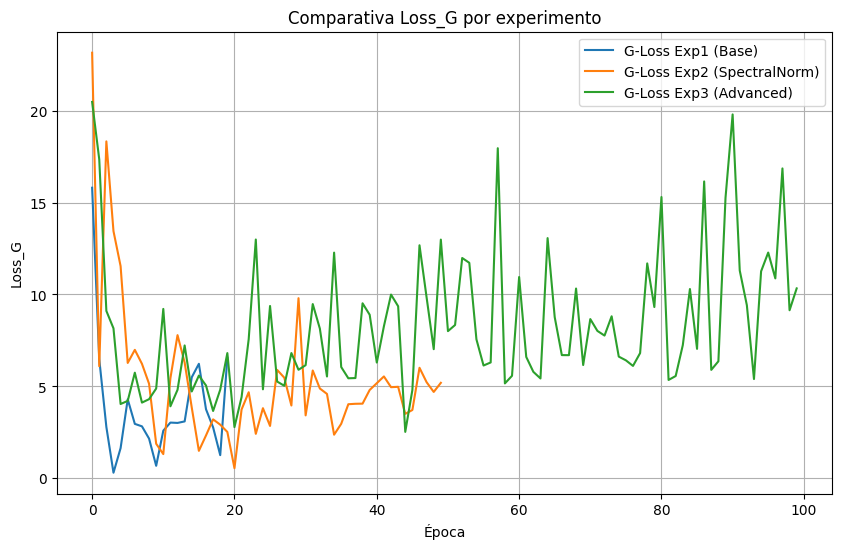

In [19]:
plt.figure(figsize=(10,6))

plt.plot(exp1_G, label="G-Loss Exp1 (Base)")
plt.plot(exp2_G, label="G-Loss Exp2 (SpectralNorm)")
plt.plot(exp3_G, label="G-Loss Exp3 (Advanced)")

plt.title("Comparativa Loss_G por experimento")
plt.xlabel("Época")
plt.ylabel("Loss_G")
plt.grid(True)
plt.legend()
plt.show()


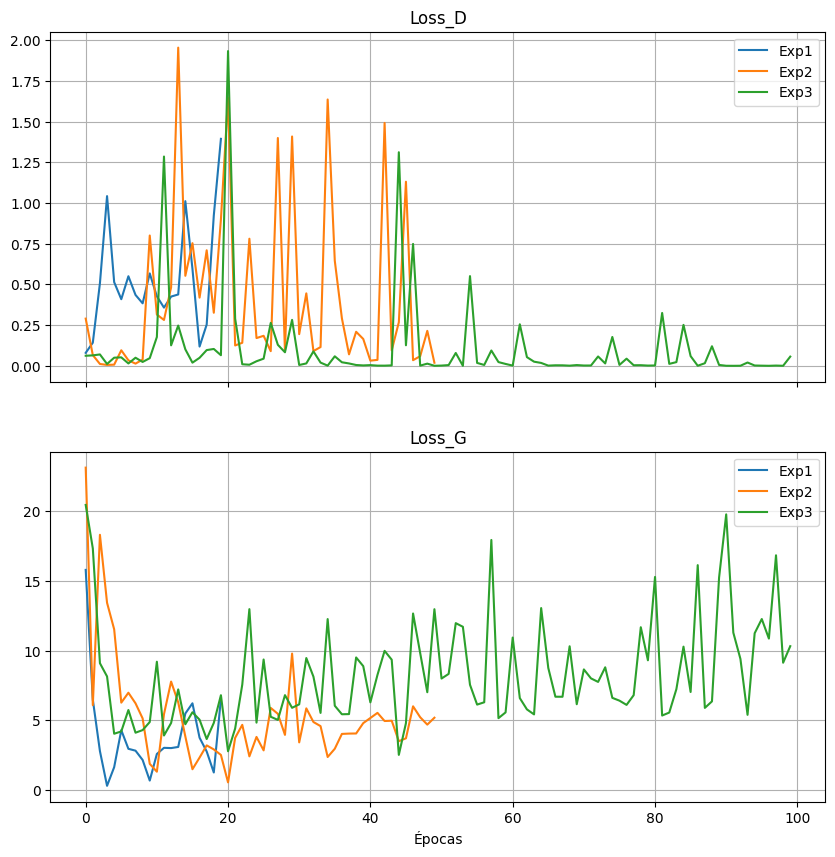

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)

ax[0].plot(exp1_D, label="Exp1")
ax[0].plot(exp2_D, label="Exp2")
ax[0].plot(exp3_D, label="Exp3")
ax[0].set_title("Loss_D")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(exp1_G, label="Exp1")
ax[1].plot(exp2_G, label="Exp2")
ax[1].plot(exp3_G, label="Exp3")
ax[1].set_title("Loss_G")
ax[1].set_xlabel("Épocas")
ax[1].legend()
ax[1].grid(True)

plt.show()


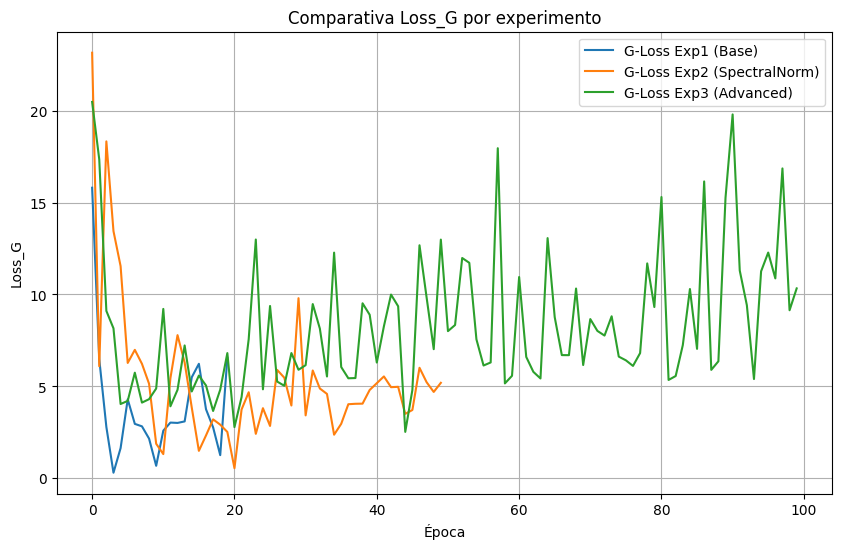

In [21]:
plt.figure(figsize=(10,6))

plt.plot(exp1_G, label="G-Loss Exp1 (Base)")
plt.plot(exp2_G, label="G-Loss Exp2 (SpectralNorm)")
plt.plot(exp3_G, label="G-Loss Exp3 (Advanced)")

plt.title("Comparativa Loss_G por experimento")
plt.xlabel("Época")
plt.ylabel("Loss_G")
plt.grid(True)
plt.legend()
plt.show()

Prueba generando imagen

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- EXPERIMENTO 1 ---
G1 = Generator(latent_dim=100, feature=64).to(device)
G1.load_state_dict(torch.load("models/exp1_base_G.pth", map_location=device))
G1.eval()

# --- EXPERIMENTO 2 ---
G2 = Generator(latent_dim=128, feature=64).to(device)
G2.load_state_dict(torch.load("models/exp2_intermediate_G.pth", map_location=device))
G2.eval()

# --- EXPERIMENTO 3 ---
G3 = Generator(latent_dim=128, feature=64).to(device)
G3.load_state_dict(torch.load("models/exp3_advanced_G.pth", map_location=device))
G3.eval()

print("Modelos cargados con éxito")


Modelos cargados con éxito


In [23]:
import numpy as np
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def generar_logos(modelo, latent_dim, num_imagenes=16):
    modelo.eval()

    with torch.no_grad():
        noise = torch.randn(num_imagenes, latent_dim, 1, 1, device=device)
        fake_images = modelo(noise).cpu()

    grid = make_grid(
        fake_images,
        nrow=int(np.sqrt(num_imagenes)),
        normalize=True,
        padding=2
    )
    return grid


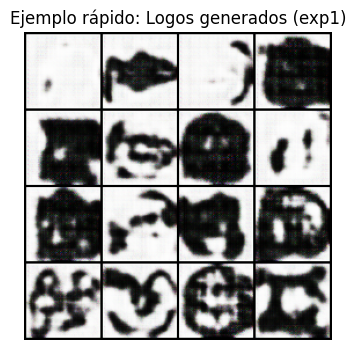

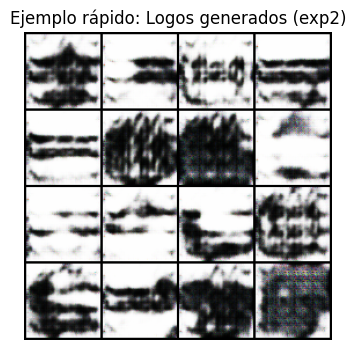

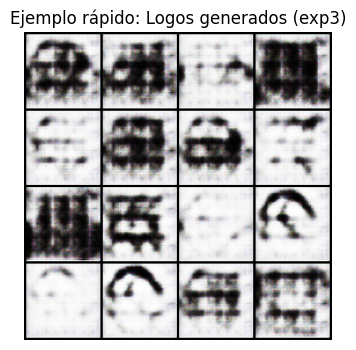

In [24]:
plt.figure(figsize=(4,4))
plt.title("Ejemplo rápido: Logos generados (exp1)")
plt.imshow(np.transpose(generar_logos(G1, 100).numpy(), (1,2,0)))
plt.axis("off")
plt.show()

plt.figure(figsize=(4,4))
plt.title("Ejemplo rápido: Logos generados (exp2)")
plt.imshow(np.transpose(generar_logos(G2, 128).numpy(), (1,2,0)))
plt.axis("off")
plt.show()

plt.figure(figsize=(4,4))
plt.title("Ejemplo rápido: Logos generados (exp3)")
plt.imshow(np.transpose(generar_logos(G3, 128).numpy(), (1,2,0)))
plt.axis("off")
plt.show()


In [32]:
# ============================================
# 🧠 Generar 1 logo aleatorio con el modelo exp1
# ============================================

import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Configuración del modelo
latent_dim = 100        # exp1 usa 100
feature = 64            # mismo que en tu Generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciar el generador (exp1)
G = Generator(latent_dim=latent_dim, feature=feature).to(device)

# Cargar pesos entrenados
G.load_state_dict(torch.load("models/exp1_base_G.pth", map_location=device))
G.eval()

print("✔️ Generador exp1 cargado correctamente")


def generar_logo():
    """
    Genera un único logotipo aleatorio usando exp1.
    Retorna un array numpy listo para visualizar.
    """
    with torch.no_grad():
        # Generar ruido
        noise = torch.randn(1, latent_dim, 1, 1, device=device)
        fake_img = G(noise).cpu()

    # Desnormalizar de (-1, 1) a (0, 1)
    img = (fake_img * 0.5 + 0.5)

    # Convertir a numpy HWC
    img_np = img.squeeze(0).permute(1, 2, 0).numpy()

    return img_np


✔️ Generador exp1 cargado correctamente


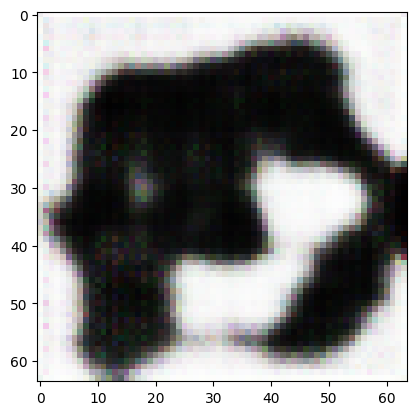

In [36]:
logo = generar_logo()
plt.imshow(logo)